<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-Логистической-регрессии." data-toc-modified-id="Модель-Логистической-регрессии.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель Логистической регрессии.</a></span></li><li><span><a href="#Модель-DecisionTreeClassifier." data-toc-modified-id="Модель-DecisionTreeClassifier.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель DecisionTreeClassifier.</a></span></li><li><span><a href="#Тестирование-лучшей-модели." data-toc-modified-id="Тестирование-лучшей-модели.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тестирование лучшей модели.</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В данном проекте будет проведено обучение моделей классифицировать комментарии на позитивные и негативные. Для обучения моделей в нашем распоряжении имеется набор данных с разметкой о токсичности правок.

Как итог будет построена модель со значением метрики качества *F1* не меньше 0.75. 

**Проект будет выполнен по следующим этапам**

1. Загрузка и подготовка данных.
2. Обучение разных моделей. 
3. Формирование выводов.



**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import catboost
import lightgbm 
import pandas as pd
import numpy as np
import re 
import time
import nltk
#from pymystem3 import Mystem
from nltk.corpus import wordnet
from nltk import word_tokenize as word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords 
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (TimeSeriesSplit,
                                     train_test_split,
                                     RandomizedSearchCV, GridSearchCV)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import f1_score
from tqdm import tqdm
from tqdm import notebook 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим данные.

In [7]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv(r"C:\Users\tzslapin\Downloads\toxic_comments.csv")

In [8]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
data.tail(5)

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


Видим неизвестный лишний столбец. Ничего с ним делать не будем.

In [10]:
data.sample(5)

,Unnamed: 0,text,toxic
42393,42443,PS Ideally an article in WP should have at lea...,0
83330,83409,"Stay out of my business \n\nGo ahead, keep it ...",1
65736,65803,"Sup dude. I'm not spamming. Fuck you, learn to...",1
1431,1431,"""Short for the spanish word """"Cohete"""", which ...",0
14802,14818,"You are a vandal, you removed the reference to...",1


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Всего записей в датасете 159292. Текст на английском языке.

Создадим функции для "очистки" и лемматизации текста.

In [12]:
def clear (text):
    regular = re.sub(r'^[a-zA-Z]', ' ', text)
    clear = ' '.join(regular.split())
    return clear

In [13]:
#m = Mystem()

In [14]:
# def lemmatize(text):
#     lemm_list = m.lemmatize(text)
#     text_lemm = ' '.join(lemm_list)
#     return text_lemm

In [15]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return ' '.join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))])

lemmatize_sent('He is walking to school')

'he be walk to school'

Для экономии ресурсов настройку произведем на выборке из 1000 записей. После настройки обучим модель на всем датасете, а выборку из 1000 записей закоментим.

In [16]:
#data_1 = data.sample(1000).reset_index(drop=True)

In [17]:
#data_1['text'] = data_1['text'].apply(clear)

In [18]:
tqdm.pandas()
data['text'] = data['text'].progress_apply(clear)

100%|██████████| 159292/159292 [00:01<00:00, 82857.82it/s]


In [19]:
tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemmatize_sent)

100%|██████████| 159292/159292 [09:45<00:00, 272.04it/s]


In [20]:
data['text'][0]

"xplanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [21]:
data['lemm_text'][0]

"xplanation why the edits make under my username hardcore metallica fan be revert ? they be n't vandalisms , just closure on some gas after i vote at new york doll fac . and please do n't remove the template from the talk page since i 'm retired now.89.205.38.27"

In [22]:
data['text'] = data['text'].str.lower()

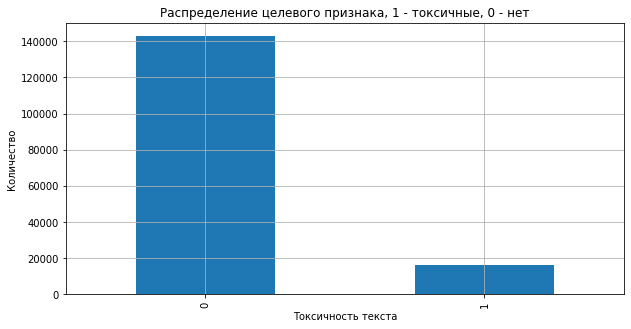

In [23]:
data['toxic'].value_counts().plot(kind='bar', figsize = (10, 5), title = 'Распределение целевого признака, 1 - токсичные, 0 - нет', \
                                  xlabel = 'Токсичность текста', ylabel = 'Количество', grid = True);


Целевой признак несбалансирован. При разбиении на выборки будем использовать стратификацию.

In [24]:
features = data['text']
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size = TEST_SIZE, 
    stratify=target, 
    random_state = RANDOM_STATE
)

**Выводы по подготовке:**


На этапе подготовки выполнены следующие действия:

- Перевели столбец 'text' в кодировку Unicod;
- очистили текст функцией clear;
- лемматизировали текст,;
- привели текст к нижнему регистру;
- проверили текст на дубликаты;
- разделили на тренировочную и тестовую выборки.

## Обучение

Для сравнения составим таблицу.

In [25]:
table = pd.DataFrame(columns=['name_model', 'best_score', 
                                   'parameters', 'time, sec'])

Создадим функцию для добавления в созданную таблицу характеристик работы моделей.

In [26]:
def model_metrics(name_model, best_score, params, time):
    global table
    if name_model not in list(table['name_model']):
        new_row = {'name_model': name_model, 'best_score': best_score, 'parameters': params, 'time, sec': time}
        table = table.append(new_row, ignore_index=True)
        display(table)  

Создадим функцию, которая принимает пайплайн модели, а возвращает имя модели, лучшую метрику, параметры и время обучения.

In [27]:
def model_creation(pipeline, parametrs, name):
    for _ in tqdm(range(1)): 
        start = time.time()
        randomized_search = RandomizedSearchCV(pipeline, parametrs, scoring='f1', n_iter=5, n_jobs=-1)
        randomized_search.fit(features_train, target_train)  
        model_metrics(name, randomized_search.best_score_, 
                      randomized_search.best_params_, time.time() - start)

### Модель Логистической регрессии.

In [28]:
pipe_lr = Pipeline([
                    ('vect', TfidfVectorizer(stop_words = stopwords)),
                    ('model', LogisticRegression(random_state = RANDOM_STATE, solver='liblinear'))
                  ])

In [29]:
params_lr = {
             'model__C': range(5, 16),
             'model__class_weight': ['balanced'],
             'model__penalty': ['l1','l2']
            }

In [30]:
model_creation(pipe_lr, params_lr, 'LogisticRegression')

  0%|          | 0/1 [00:00<?, ?it/s]

,name_model,best_score,parameters,"time, sec"
0,LogisticRegression,0.76527,"{'model__penalty': 'l2', 'model__class_weight'...",572.489662


100%|██████████| 1/1 [09:32<00:00, 572.50s/it]


### Модель DecisionTreeClassifier.

In [31]:
pipe_dtc = Pipeline([("vect", TfidfVectorizer(stop_words='english')), 
                     ("dtc", DecisionTreeClassifier(random_state = RANDOM_STATE))])

In [32]:
params_dtc = {'dtc__max_depth': ([x for x in range(1, 25)]),
              'dtc__class_weight': (['balanced'])}

In [33]:
model_creation(pipe_dtc, params_dtc, 'DecisionTreeClassifier')

  0%|          | 0/1 [00:00<?, ?it/s]

,name_model,best_score,parameters,"time, sec"
0,LogisticRegression,0.765270,"{'model__penalty': 'l2', 'model__class_weight'...",572.489662
1,DecisionTreeClassifier,0.593047,"{'dtc__max_depth': 16, 'dtc__class_weight': 'b...",313.876921


100%|██████████| 1/1 [05:13<00:00, 313.89s/it]


**Выводы по обучению:**
1. Создали и обучили модели с использованием RandomizedSearchCV:
    - Логистическую регрессию.
    - DecisionTreeClassifier.
2. По итогам обучения метрики f1 при кросс валидации составили:
    - Логистическая регрессия - 0.765053
    - DecisionTreeClassifier - 0.602553
3. По метрике f1  лучшие показатели у модели Логистической регрессии.

### Тестирование лучшей модели.

In [34]:
best_model = Pipeline([
                    ('vect', TfidfVectorizer(stop_words = stopwords)),
                    ('model', LogisticRegression(random_state = RANDOM_STATE,
                                solver='liblinear', 
                                class_weight = None,
                                C = 10))
                  ])


In [35]:
best_model.fit(features_train, target_train) 

f1 = f1_score(target_test, best_model.predict(features_test))
print(f1)

0.7715083798882683


Метрика лучшей модели на тестовой выборке составила 0.77 - соответствует условию.

## Выводы

In [36]:
table['parameters'][0]

{'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 9}

В данной работе выполнены следующие этапы:

1. Загрузка и подготовка данных.

    - Перевели столбец 'text' в кодировку Unicod;
    - очистили текст функцией clear;
    - лемматизировали текст,;
    - привели текст к нижнему регистру;
    - проверили текст на дубликаты;
    - разделили на тренировочную и тестовую выборки.
    
    
2. Обучение разных моделей. Создали и обучили две модели:
    - Логистическую регрессию.
    - DecisionTreeClassifier.
    
Лучшей моделью признана модель Логистической регрессии со следующими параметрами:
- 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 12
- Метрика f1 модели на кросс-валидации составила 0.765053
- Метрика f1 модели на тестовой выборке 0.77.


3. Рекомендация Заказчику:
 - Для оценки токсичности комментариев использовать модель Логистической регрессии с вышеуказанными параметрами.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны